<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
from numpy import asarray
from numpy import arange
from numpy.random import rand
import numpy as np
import matplotlib.pyplot as plt

In [41]:
# Task 1
# Find the roots of square equation by gradient descent
# x ** 2 - 6 * x + 4 = 0

# возвести в квадрат
# посчитать производную
# надо начать движение от начальной точки в направлении антградиента с заданным шагом
# x = x - lr * grad(x)


In [2]:
def f(x):
    return x*x - 6*x + 4   

def sqr_f(x):
    return f(x) ** 2

def deriv_sqr_f(x):
    return 2 * (x ** 2 - 6 * x + 4) * (2 * x - 6)

<Figure size 1152x648 with 0 Axes>

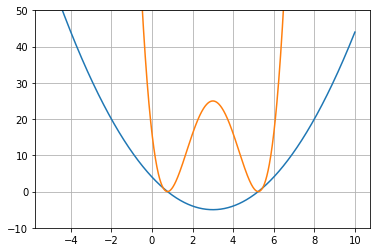

In [3]:
x = np.linspace(-5, 10, 1000)

y = f(x)
y_sqr = sqr_f(x)
plt.figure(figsize=(16, 9))
fig, ax = plt.subplots()  
ax.grid(True)   
plt.ylim([-10, 50])

ax.plot(x, y)
ax.plot(x, y_sqr)
plt.show()


0.7639320225002102


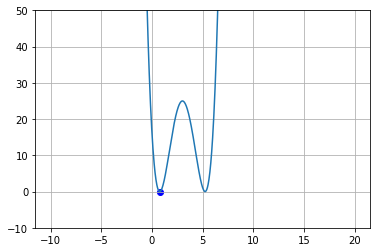

In [4]:
N = 100  
x_1 = 0   
lr = 0.01  

x_plt = np.linspace(-10, 20, 1000)

f_plt = [sqr_f(x) for x in x_plt]

fig, ax = plt.subplots()  
ax.grid(True)  

ax.plot(x_plt, f_plt)   

for i in range(N):
    x_1 = x_1 - lr * deriv_sqr_f(x_1)   

print(x_1)

ax.scatter(x_1, sqr_f(x_1), c = 'blue')
plt.ylim([-10, 50])
plt.show()
    

5.236067977499791


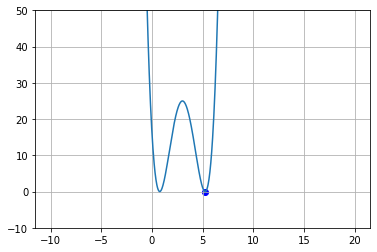

In [5]:
N = 100  
x_2 = 7   
lr = 0.01 


x_plt = np.linspace(-10, 20, 1000)

f_plt = [sqr_f(x) for x in x_plt]

fig, ax = plt.subplots()  
ax.grid(True)   


ax.plot(x_plt, f_plt)    


for i in range(N):
    x_2 = x_2 - lr * deriv_sqr_f(x_2)   

print(x_2)
ax.scatter(x_2, sqr_f(x_2), c = 'blue')
plt.ylim([-10, 50])
plt.show()

In [ ]:
# всегда ли сойдемся за приемлемое количество шагов?
        # ОТВЕТ: Зависит от выбранного ЛР
# важна ли начальная точка?
        #ОТВЕТ: Да, от этого зависит результат. Если неверно выбрать начальную точку - попадем не в тот минимум
# как найти второй корень?
        #ОТВЕТ: Подобрать другую начальную точку
# AssertionErrorкак вляет ЛР?
        #ОТВЕТ: Вляет на скорость. Если выбрать большой - перескочим, слишком маленький - не дойдем

In [ ]:
# Task 2

In [6]:
pip install torchvision


Note: you may need to restart the kernel to use updated packages.


In [7]:
import torch

In [31]:
def sigmoid(x):
    return 1. / (1 + torch.exp(-x))

def sigmoid_backward(da, x):
    sig = sigmoid(x)

    return da * sig * (1 - sig)

def relu(x):
    return torch.maximum(torch.zeros(1), x)

def relu_backward(da, x):
    da = torch.tensor(da)
    da[x <= 0] = 0
    return da


In [32]:
def mse_loss(t, y):
    return (t - y) ** 2

def d_mse_loss(t, y):
    return 2 * (y - t)

In [33]:
class LinearLayer:
    def __init__(self, n_inp, n_out, activation='sigmoid'):
        self.w = torch.rand(n_out, n_inp) * 0.1
        self.b = torch.rand(n_out, 1) * 0.1
        #print(n_inp, n_out, activation)
        if activation == 'sigmoid':
            self.activ = sigmoid
        elif activation == 'relu':
            self.activ = relu
        elif activation == 'None':
            self.activ = None
        else:
            raise Exception(f'Unknown activation "{activation}"')
        self._clear_state()

    def _clear_state(self):
        self.lin = None
        self.inp = None
        self.d_w = None
        self.d_b = None

    def forward(self, x):
        self.inp = x
        self.lin = self.w @ x + self.b
        activ = self.activ(self.lin) if self.activ is not None else self.lin

        return activ

    def backward(self, grad): 
        if self.activ == sigmoid:
            grad_lin = sigmoid_backward(grad, self.lin)
        elif self.activ == relu:
            grad_lin = relu_backward(grad, self.lin)
        else:
            grad_lin = grad
        
        m = self.inp.shape[1]
        self.d_w = grad_lin @ self.inp.t() / m    
        
        self.d_b = torch.sum(grad_lin, axis=1, keepdims=True) / m
        grad = self.w.t() @ grad_lin

        return grad    

In [34]:
from typing import Tuple

class Model:
    def __init__(self, arch: Tuple[Tuple[int, int]], activation):
        self.layers = []
        for i, p in enumerate(arch):
            #print(i, p, activation)
            self.layers.append(
                LinearLayer(p[0], p[1], activation=activation if i < len(arch)-1 else 'None')
            )
        self._clear_state()

    def _clear_state(self):
        for l in self.layers:
            l._clear_state()

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)

        return x

    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

        return grad

In [43]:
# Task 3

In [35]:
class SGDMomentum:
    def __init__(self, model: Model, lr= 0.0001, momentum=0.99):
        self.model = model
        self.lr = lr
        self.m = momentum
        self.vel = [[torch.zeros_like(layer.w),
                     torch.zeros_like(layer.b)] for layer in model.layers]

    def step(self):
        for i, layer in enumerate(self.model.layers):
            self.vel[i][0] = self.vel[i][0] * self.m - self.lr * layer.d_w
            self.vel[i][1] = self.vel[i][1] * self.m - self.lr * layer.d_b
            layer.w += self.vel[i][0]
            layer.b += self.vel[i][1]

    def zero_grad(self):
        self.model._clear_state()

In [42]:
max = 2
min = -2
x = (max-min)*torch.rand(10) + min
y = x**2 + torch.rand(1)*0.1

In [44]:
model = Model(((1, 100), (100, 1)), activation='sigmoid')
optim = SGDMomentum(model, lr=0.001)
for e in range(20):
    for i, (val, t) in enumerate(zip(x, y)):
        optim.zero_grad()
        pred = model.forward(torch.tensor([[val]]))
        loss = mse_loss(t, pred)
        grad = d_mse_loss(t, pred)
        model.backward(grad)
        optim.step()
    print(e, model.forward(torch.tensor([[1.]])), model.forward(torch.tensor([[2.]])), model.forward(torch.tensor([[-1.]])), model.forward(torch.tensor([[-2.]])))


0 tensor([[-0.3460]]) tensor([[-0.3552]]) tensor([[-0.3273]]) tensor([[-0.3180]])
1 tensor([[1.1685]]) tensor([[1.1893]]) tensor([[1.1267]]) tensor([[1.1058]])
2 tensor([[1.8779]]) tensor([[1.9087]]) tensor([[1.8160]]) tensor([[1.7850]])
3 tensor([[-0.4305]]) tensor([[-0.4547]]) tensor([[-0.3816]]) tensor([[-0.3572]])
4 tensor([[1.8797]]) tensor([[1.8947]]) tensor([[1.8496]]) tensor([[1.8346]])
5 tensor([[0.9575]]) tensor([[0.9431]]) tensor([[0.9864]]) tensor([[1.0008]])
6 tensor([[0.0052]]) tensor([[-0.0405]]) tensor([[0.0973]]) tensor([[0.1432]])
7 tensor([[1.9917]]) tensor([[1.9648]]) tensor([[2.0458]]) tensor([[2.0727]])
8 tensor([[0.2549]]) tensor([[0.1751]]) tensor([[0.4154]]) tensor([[0.4952]])
9 tensor([[0.5543]]) tensor([[0.4503]]) tensor([[0.7639]]) tensor([[0.8681]])
10 tensor([[1.6121]]) tensor([[1.4846]]) tensor([[1.8693]]) tensor([[1.9968]])
11 tensor([[-0.1533]]) tensor([[-0.3553]]) tensor([[0.2549]]) tensor([[0.4569]])
12 tensor([[0.8639]]) tensor([[0.6089]]) tensor([[1